The dataset is a custom one -> has a few catgories of landscapes. (Replace with any data in folderwise. One for each class.)

In [59]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST, ImageFolder
from torchvision import datasets, transforms
import torchsnooper as sn
from pytorch_lightning import Trainer
import torchvision.models as models
from collections import Counter
from pytorch_lightning import loggers as pl_loggers
import numpy as np
import pickle
import os

os.environ["TORCH_HOME"] = "~/Desktop/Datasets/"

# Create model

In [78]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, learning_rate=2e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape

        self.encoder = nn.Sequential(
            nn.Linear(np.prod(self.dim), 64), nn.ReLU(), nn.Linear(64, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, np.prod(self.dim))
        )

    def forward(self, x):
        print(self.dim, np.prod(self.dim))
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss_step", loss)
        return loss

    def val_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("val_loss_step", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("test_loss_step", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Load data

In [24]:
class ImDataModule(pl.LightningDataModule):
    def __init__(
        self, batch_size, data_dir: str = "/home/eragon/Desktop/Datasets/LandscapeSort/"
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Augmentation policy
        self.augmentation = transforms.Compose(
            [
                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15),
                transforms.RandomHorizontalFlip(),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        self.transform = transforms.Compose(
            [
                transforms.Resize(size=256),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def setup(self, stage=None):
        # build dataset
        im_dataset = ImageFolder(self.data_dir)
        # split dataset
        self.train, self.val, self.test = random_split(im_dataset, [80, 10, 9])
        self.train.dataset.transform = self.augmentation
        print(dict(Counter(self.train.dataset.targets)))
        print(self.train.dataset.class_to_idx)
        self.val.dataset.transform = self.transform
        self.test.dataset.transform = self.transform
        return self.train.dataset.class_to_idx

    def train_dataloader(self):
        return DataLoader(
            self.train, batch_size=self.batch_size, shuffle=True, num_workers=12
        )

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=12)

In [25]:
dm = ImDataModule(batch_size=64)
class_ids = dm.setup()

{0: 16, 1: 22, 2: 36, 3: 25}
{'Desert': 0, 'Fields': 1, 'Mountain': 2, 'Water': 3}


In [26]:
# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

# Logs

In [30]:
model = LitModel((3, 224, 224))

In [31]:
tb_logger = pl_loggers.TensorBoardLogger("./lightning_logs/")

In [32]:
trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=1,
    precision=16,
    profiler=False,
    max_epochs=100,
    callbacks=[pl.callbacks.ProgressBar()],
    automatic_optimization=True,
    logger=tb_logger,
    enable_pl_optimizer=True,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [33]:
trainer.fit(model, dm)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 9.6 M 
1 | decoder | Sequential | 9.8 M 
---------------------------------------
19.4 M    Trainable params
0         Non-trainable params
19.4 M    Total params


1

In [34]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss_step': tensor(1.5906, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss_step': 1.5905601978302002}]

In [35]:
trainer.save_checkpoint("model1.ckpt")

# Inference

In [36]:
from PIL import Image

In [102]:
transform = transforms.Compose(
    [
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [103]:
m1 = LitModel.load_from_checkpoint("model1.ckpt")

In [104]:
t_path = "/home/eragon/Documents/"

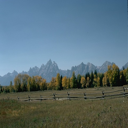

In [105]:
im_sh = Image.open(
    "/home/eragon/Desktop/Datasets/BSDS300/images/train/2092.jpg"
).convert("RGB")
im_sh.resize((128, 128))

In [106]:
test = transform(im_sh)

In [107]:
test.size()

torch.Size([3, 224, 335])

In [109]:
m1(test)

(3, 224, 224) 150528


RuntimeError: mat1 and mat2 shapes cannot be multiplied (672x335 and 150528x64)

In [101]:
224 * 224 * 3

150528

In [102]:
pred = class_ids[int(torch.argmax(m1(test), 1))]
pred

'Fields'